#### Gets a quick estimate of the noise level (for initilization of the Gibbs chains), given the image standard deviation.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

from data import GDiff_dataset
from gibbs_diffusion.model import load_model
from inference_utils.utils_hmc import ColoredPS

import inference_utils.utils_hmc as iut
from utils import get_colored_noise_2d
from sklearn.linear_model import LinearRegression

In [3]:
device = 0

# Target parameters
norm_phi_mode = 'compact' # Normalization mode for phi among ['compact', 'inf', None]
sigma_min, sigma_max = 0.01, 1.0 # Bounds for sigma (no normalization). 0.01 leads to timestep of 1 -> we should not consider lower values with the current model.

# Inference parameters
num_samples = 68

In [4]:
# Load dataset, diffusion model, and power spectrum model
dataset = GDiff_dataset(dataset="cbsd68")
model = load_model(device=device)
ps_model = ColoredPS(norm_input_phi=norm_phi_mode)

In [5]:
#
# Prior, likelihood, and posterior functions
#

sample_phi_prior = lambda n: iut.sample_prior_phi(n, norm=norm_phi_mode, device=device) # Sample uniformly in [-1, 1]

#
# Bounds and collision management
#

phi_min_norm, phi_max_norm = iut.get_phi_bounds(device=device) #change to work in [-1,1]
phi_min_norm, phi_max_norm = iut.normalize_phi(phi_min_norm, mode=norm_phi_mode), iut.normalize_phi(phi_max_norm, mode=norm_phi_mode) #change to work in [-1,1]
sigma_min_tensor = torch.tensor([sigma_min]).to(device)
sigma_max_tensor = torch.tensor([sigma_max]).to(device)
phi_min_norm = torch.concatenate((phi_min_norm, sigma_min_tensor)) # Add sigma_min to the list of parameter bounds
phi_max_norm = torch.concatenate((phi_max_norm, sigma_max_tensor)) # Add sigma_max to the list of parameter bounds


print("Normalized prior bounds are:", phi_min_norm, phi_max_norm)

Normalized prior bounds are: tensor([0.0000, 0.0100], device='cuda:0') tensor([1., 1.], device='cuda:0')


In [6]:
#
# Make test data
#

# Sample phi, sigma, load images, and add noise
phi_true = sample_phi_prior(num_samples)
sigma_true = torch.rand(num_samples, device=device) * (sigma_max - sigma_min) + sigma_min
ps_test = ps_model(phi=phi_true) # power spectrum corresponding to phi_test (taking into account the normalization)
sigma_test_timestep, _ = model.get_closest_timestep(sigma_true, model)
alpha_bar_t = model.alpha_bar_t[sigma_test_timestep.cpu()].reshape(-1, 1, 1, 1).to(device)
x = []
for i in range(num_samples):
    x.append(dataset[i][0].to(device))
x = torch.stack(x)
eps = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t)*get_colored_noise_2d((num_samples, 3, 256, 256), phi_true).to(device) # get_colored_noise_2d needs unnormalized parameters
y = x + eps # Noisy image
yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

In [7]:
sigma_true

tensor([0.2829, 0.5926, 0.4248, 0.1663, 0.2036, 0.5676, 0.1937, 0.9881, 0.6477,
        0.3050, 0.4587, 0.5228, 0.1917, 0.4609, 0.2435, 0.5787, 0.5112, 0.1826,
        0.2022, 0.7634, 0.8842, 0.7743, 0.9828, 0.3374, 0.2634, 0.9330, 0.0139,
        0.6935, 0.3314, 0.4044, 0.9033, 0.6067, 0.1591, 0.6710, 0.1937, 0.3414,
        0.8783, 0.4559, 0.5422, 0.3747, 0.9520, 0.4129, 0.6280, 0.9344, 0.7832,
        0.1965, 0.0944, 0.8871, 0.6983, 0.8503, 0.2368, 0.1344, 0.5115, 0.6834,
        0.7254, 0.3976, 0.2474, 0.7957, 0.0687, 0.6643, 0.6795, 0.0999, 0.5830,
        0.6274, 0.5319, 0.4482, 0.0474, 0.9684], device='cuda:0')

In [8]:
y_std = y.std(dim=(1,2,3))

In [9]:
y = sigma_true.cpu().numpy()
x = y_std.cpu().numpy()

In [10]:
# Make a linear regression of y_std as a function of sigma_true
reg = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))
print("R2 score:", reg.score(x.reshape(-1, 1), y.reshape(-1, 1)))
print("Slope:", reg.coef_[0,0])
print("Intercept:", reg.intercept_[0])
print("Slope error:", np.sqrt(np.diag(reg.coef_))[0])
print("Intercept error:", np.sqrt(np.diag(reg.intercept_))[0])

R2 score: 0.9852618854279165
Slope: 1.0911896
Intercept: -0.11064112
Slope error: 1.0446002
Intercept error: [nan]


/tmp/ipykernel_1034910/1868530755.py:7: RuntimeWarning: invalid value encountered in sqrt
  print("Intercept error:", np.sqrt(np.diag(reg.intercept_))[0])


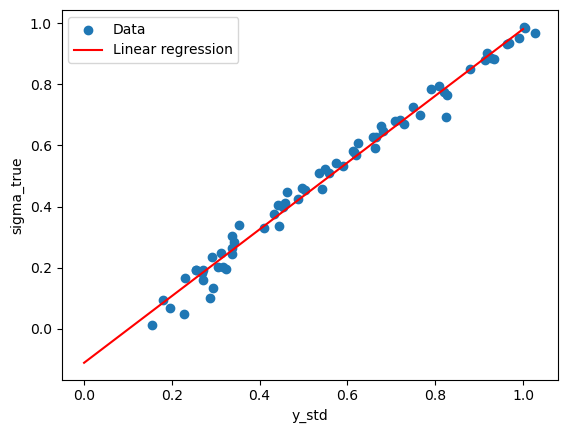

In [11]:
# Plot the results
plt.figure()
plt.scatter(x, y, label="Data")
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, reg.predict(x_plot.reshape(-1, 1)), label="Linear regression", color="red")
plt.ylabel("sigma_true")
plt.xlabel("y_std")
plt.legend()

In [12]:
id = 10
print(y_std[id]*1.13 - 0.140)
print(sigma_true[id])

tensor(0.4722, device='cuda:0')
tensor(0.4587, device='cuda:0')
